# Assignment 4 
## Network Measurements and Analysis of the Tor Network Using Open Data

### Introduction

The Tor ("The Onion Router") network is a decentralized network which allows users to browse the internet anonymously and privately. This is achieved by routing user-traffic through a set of tor-relays, combined with en- and decryption along every point of the way, referred to as onion routing. A concrete set of relays is called a circuit, mostly consisting of one entry (or "Guard") -relay, one middle-relay and the exit-relay [1]. The exit relay, being the final relay in a circuit, is the one that sends out the traffic to its destination [2]. Exit-relays are mandatory for the functionality of the system, yet they also pose the biggest risk and attack surface to the privacy and anonymity goals of the users. This is why, they have been targets of attacks in the past, for example as seen in [3], but what if, the traffic never has to leave the tor-network? To provide ultimate privacy and anonymity for the client, but also to provide responder anonymity, clients can also arrange "rendezvous" inside the tor-network or make use of the so called "onion or hidden services" [1]. Onion services provide [4]:
- Location hiding for client and responder
- End-to-end authentication
- End-to-end encryption
- NAT punching

additionally to the traffic exiting the tor-network in the first place. These onion services are what this assignement is mostly about, its trying to answer the question:

__What is the cost of this ultimate privacy? How do page load times on tor onion services compare to their clear web counterparts?__


### Data Collection



In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Load CSV data
df = pd.read_csv('onion_vs_clearnet_comparison_with_relays.csv')

                  Avg Clear Web Load Time (ms)  Avg Onion Load Time (ms)  \
Clear Domain                                                               
theguardian.com                         441.70                  19263.20   
brave.com                               369.20                  10228.80   
amnesty.org                             817.00                  10063.90   
f-droid.org                             509.15                   5315.25   
mullvad.net                             636.45                   6038.90   
taz.de                                  623.60                   5792.25   
svoboda.org                            1304.25                  11655.20   
cock.li                                 260.00                   2279.70   
mediapart.fr                            491.90                   4005.70   
proton.me                               495.45                   4017.40   
guardian.co.uk                          486.30                   3588.35   
marxists.org

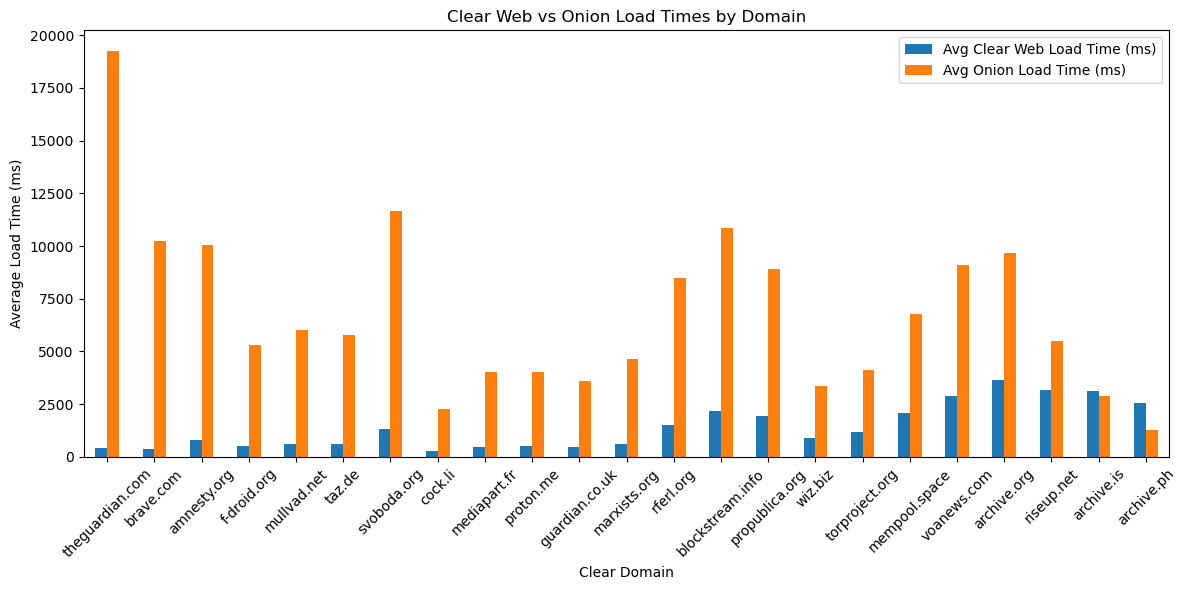

In [13]:
# Filter types
onion_df = df[df['Type'] == 'onion']
clear_df = df[df['Type'] == 'clear']

# Average total load times per domain
avg_onion = onion_df.groupby('Clear Domain')['Total Time (ms)'].mean()
avg_clear = clear_df.groupby('Clear Domain')['Total Time (ms)'].mean()

# Combine both averages
summary = pd.DataFrame({
    'Avg Clear Web Load Time (ms)': avg_clear,
    'Avg Onion Load Time (ms)': avg_onion
})

# Calculate slowdown factor
summary['Slowdown Factor'] = summary['Avg Onion Load Time (ms)'] / summary['Avg Clear Web Load Time (ms)']

# Drop NaNs if any (in case a domain is only in one set)
summary = summary.dropna()

# Print summary table
print(summary.sort_values(by='Slowdown Factor', ascending=False))

# Plotting
summary.sort_values('Slowdown Factor', ascending=False).plot(
    kind='bar',
    y=['Avg Clear Web Load Time (ms)', 'Avg Onion Load Time (ms)'],
    figsize=(12, 6),
    title='Clear Web vs Onion Load Times by Domain',
    rot=45
)

plt.ylabel('Average Load Time (ms)')
plt.tight_layout()
plt.show()

In [11]:
from collections import defaultdict

# Filter only onion URLs
onion_df = df[df['Type'] == 'onion'].copy()

country_counts = defaultdict(int)
relays_per_domain = defaultdict(set)
all_unique_relays = set()
all_unique_circuits = set()

for _, row in onion_df.iterrows():
    domain = row['Clear Domain']
    relays = row['Circuit Relays (Onion only)']
    if pd.isna(relays):
        continue

    relay_fingerprints = []
    for relay in relays.split(';'):
        parts = relay.strip().split(':')
        if len(parts) == 4:
            fingerprint, nickname, ip, country = parts
            # Only count known countries
            if country.lower() != 'unknown':
                country_counts[country] += 1
            relays_per_domain[domain].add(fingerprint)
            all_unique_relays.add(fingerprint)
            relay_fingerprints.append(fingerprint)

    # Each circuit is a 3-relay configuration (list of 3 fingerprints)
    if len(relay_fingerprints) == 3:
        all_unique_circuits.add(tuple(relay_fingerprints))

print("\nRelay Country Usage Summary (excluding 'Unknown'):")
for country, count in sorted(country_counts.items(), key=lambda x: -x[1]):
    print(f"{country}: {count}")

print("\nUnique Relays per .onion Domain:")
for domain, relay_set in relays_per_domain.items():
    print(f"{domain}: {len(relay_set)} unique relays")

print(f"\nTotal unique relays in dataset: {len(all_unique_relays)}")
print(f"Total unique 3-relay Tor circuits in dataset: {len(all_unique_circuits)}")



Relay Country Usage Summary (excluding 'Unknown'):
DE: 339
NL: 329
ES: 178
SE: 124
PL: 114
FR: 30
US: 29
FI: 22
GB: 12
CZ: 12
CH: 5
LV: 4
UA: 3
MD: 3
BG: 3
EE: 3
DK: 2
BE: 2
AT: 2
IT: 2
RO: 2
NO: 2
RU: 1
GR: 1
HU: 1
LT: 1

Unique Relays per .onion Domain:
archive.org: 26 unique relays
theguardian.com: 26 unique relays
brave.com: 26 unique relays
guardian.co.uk: 26 unique relays
voanews.com: 25 unique relays
proton.me: 26 unique relays
amnesty.org: 26 unique relays
propublica.org: 26 unique relays
archive.is: 26 unique relays
rferl.org: 26 unique relays
mullvad.net: 26 unique relays
archive.ph: 26 unique relays
mempool.space: 26 unique relays
taz.de: 22 unique relays
marxists.org: 25 unique relays
wiz.biz: 26 unique relays
f-droid.org: 26 unique relays
cock.li: 26 unique relays
mediapart.fr: 26 unique relays
riseup.net: 26 unique relays
blockstream.info: 26 unique relays
svoboda.org: 26 unique relays
torproject.org: 6 unique relays

Total unique relays in dataset: 375
Total unique 3-re